# Metabolic Syndrome Predictions
#### Neural Network Models

*Chrisitina Brockway*

### Load Data and Imports

In [1]:
#Basic Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Preprocessing tools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#Evaluation tools
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from tensorflow import metrics

from sklearn import set_config, config_context
set_config(transform_output='pandas')
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)

# Set random seeds for consistent outcomes
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):
       
    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]
    
    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)
    
    # For each metric
    for i, metric_name in enumerate(metrics):
    
        # Get the axis for the current metric
        ax = axes[i]
    
        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch
    
        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)
    
        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)
    
        # Final subplot adjustments 
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes


In [3]:
df= pd.read_csv('data/clean_MetS.csv', index_col='seqn')
df.head()

,Age,Sex,Marital,Income,Race,Waist,BMI,AlbRating,UrAlbCr,UricAcid,Glucose,HDL,Triglycerides,MetS
seqn,,,,,,,,,,,,,,
62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


In [4]:
df.duplicated().sum()

0

In [5]:
df.isna().sum()

Age                0
Sex                0
Marital          208
Income           117
Race               0
Waist             85
BMI               26
AlbRating          0
UrAlbCr            0
UricAcid           0
Glucose            0
HDL                0
Triglycerides      0
MetS               0
dtype: int64

*  Since target is string will need need to replce values with 0 for no metabolic syndrome and 1 for Metabolic syndrome

In [6]:
df['MetS']=df['MetS'].replace({'No MetSyn': 0, 'MetSyn': 1})
df['MetS'].value_counts()

0    1579
1     822
Name: MetS, dtype: int64

### Preprocess Data for Machine Learning

In [7]:
# Train Test Split
X= df.drop(columns='MetS')
y=df['MetS'].copy()

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [8]:
X_train.head()

,Age,Sex,Marital,Income,Race,Waist,BMI,AlbRating,UrAlbCr,UricAcid,Glucose,HDL,Triglycerides
seqn,,,,,,,,,,,,,
63211,46,Female,Married,8200.0,White,124.0,40.8,0,18.47,3.3,140,53,198
70548,34,Male,Separated,3500.0,MexAmerican,86.2,24.5,0,16.14,6.1,114,83,60
64722,33,Female,Married,3500.0,MexAmerican,75.0,25.0,0,11.54,3.4,97,44,60
69237,49,Female,Married,9000.0,Hispanic,95.7,33.3,0,3.81,2.7,89,51,139
65286,30,Male,Married,9000.0,Asian,75.7,21.9,0,7.76,7.1,81,58,394


In [12]:
ordcol = X_train[['AlbRating']].columns
catcol = X_train.select_dtypes('object').columns
numcol = X_train.select_dtypes('number').drop(columns=ordcol).columns

In [13]:
#Instantiate the transformers
from sklearn.impute import KNNImputer
scaler=StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
knnimpute= KNNImputer(n_neighbors=3)
oheimpute = SimpleImputer(strategy='constant', fill_value='none')

In [16]:
#Create pipelines
num_pipe= make_pipeline(knnimpute, scaler)
cat_pipe= make_pipeline(oheimpute, ohe)

In [18]:
num_tuple= ("Numeric", num_pipe, numcol)
cat_tuple=("Catagorical", cat_pipe, catcol)
ord_tuple= ("Ordinal", scaler, ordcol)
preprocessor = ColumnTransformer([num_tuple, cat_tuple, ord_tuple], remainder='passthrough')

In [19]:
preprocessor.fit(X_train)
X_train_tf=preprocessor.transform(X_train)
X_test_tf=preprocessor.transform(X_test)

### Build Model 1

In [20]:
# Save the number of features we have as our input shape
input_shape = X_train_tf.shape[1]
input_shape

24

In [21]:
# Step 1 Build Network Structure

# Sequential model
model = keras.Sequential()

model.add(Dense(20, input_dim=input_shape, activation ='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation = 'sigmoid'))

#Step 2: compile
model.compile(loss = 'bce', optimizer = 'adam'
              ,metrics=['accuracy', metrics.Precision(), metrics.Recall()])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                500       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Use Early Stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=3)

In [23]:
history = model.fit(X_train_tf, y_train,
                        validation_split=.2,
                        epochs=50, callbacks = [early_stop])

Epoch 1/50
45/45 [==============================] - 2s 13ms/step - loss: 0.6696 - accuracy: 0.6833 - precision: 0.6148 - recall: 0.1550 - val_loss: 0.6380 - val_accuracy: 0.6944 - val_precision: 0.7857 - val_recall: 0.2463
Epoch 2/50
45/45 [==============================] - 0s 2ms/step - loss: 0.5986 - accuracy: 0.7590 - precision: 0.8624 - recall: 0.3368 - val_loss: 0.5547 - val_accuracy: 0.7444 - val_precision: 0.8281 - val_recall: 0.3955
Epoch 3/50
45/45 [==============================] - 0s 3ms/step - loss: 0.5078 - accuracy: 0.7917 - precision: 0.8382 - recall: 0.4711 - val_loss: 0.4528 - val_accuracy: 0.8028 - val_precision: 0.8182 - val_recall: 0.6045
Epoch 4/50
45/45 [==============================] - 0s 3ms/step - loss: 0.4288 - accuracy: 0.8299 - precision: 0.8170 - recall: 0.6364 - val_loss: 0.3861 - val_accuracy: 0.8194 - val_precision: 0.7717 - val_recall: 0.7313
Epoch 5/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3879 - accuracy: 0.8382 - precision: 

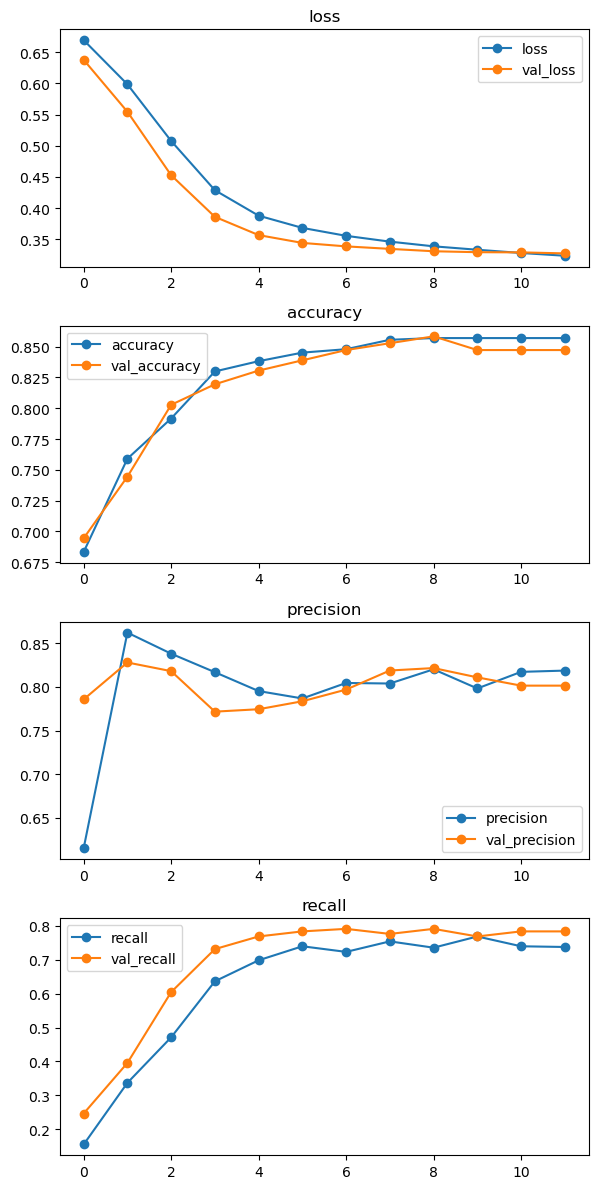

In [40]:
# Apply the custom function plot_history() to see how your model is doing
plot_history(history);
plt.savefig('Images/RNN-default')

In [25]:
# make predictions
y_pred_test= model.predict(X_test_tf)
y_pred_test[:5]

19/19 [==============================] - 0s 2ms/step


array([[0.2089992 ],
       [0.6628618 ],
       [0.26337802],
       [0.3099183 ],
       [0.99478346]], dtype=float32)

In [26]:
#evaluate with sklearn metrics
y_pred_test = np.round(y_pred_test)
y_pred_test[:5]

array([[0.],
       [1.],
       [0.],
       [0.],
       [1.]], dtype=float32)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       397
           1       0.74      0.74      0.74       204

    accuracy                           0.82       601
   macro avg       0.80      0.80      0.80       601
weighted avg       0.82      0.82      0.82       601



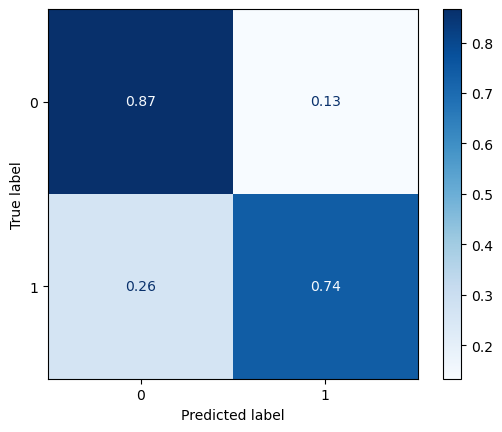

In [27]:
print(classification_report(y_test, y_pred_test))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Blues', normalize="true");

## Model 2 Tune Parameters with Keras Tuner 

Source:
https://keras.io/guides/keras_tuner/getting_started/

In [28]:
from keras_tuner import HyperParameters as hp
import keras_tuner as kt
import os
folder='KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [41]:
# Step 1 Build Network Structure

# Sequential model
def build_model(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    opitimizers = hp.Choice('optimizer', ['rmsprop','nadam','adam'])
    dropout= hp.Boolean('dropout')   
   
    model2 = Sequential()
    model2.add(Dense(units=units, activation ='relu'))
  
    if dropout:
           model2.add(Dropout(.2))
                  
    model2.add(Dense(1, activation = 'sigmoid'))

#Step 2: compile
    model2.compile(loss = 'bce', optimizer = opitimizers,
                      metrics=['accuracy'])
    
    return model2

In [30]:
# define tuner object
tuner= kt.Hyperband(build_model, objective='val_accuracy',
                    max_epochs= 8,
                    directory=folder,
                    overwrite=True,
                    seed=42,
                    project_name='MetSNeural Network')

In [31]:
epochs=50
tuner.search(X_train_tf, y_train, epochs=epochs, 
             validation_data= (X_test_tf, y_test), callbacks=[early_stop])

Trial 10 Complete [00h 00m 03s]
val_accuracy: 0.8336106538772583

Best val_accuracy So Far: 0.8336106538772583
Total elapsed time: 00h 00m 25s
INFO:tensorflow:Oracle triggered exit


In [32]:
best_hps = tuner.get_best_hyperparameters()[0]
best_hps.values

{'units': 160,
 'optimizer': 'adam',
 'dropout': False,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 1,
 'tuner/round': 0}

In [33]:
# Use Early Stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=3)

In [34]:
#build model with best hp
model2 = build_model(best_hps)
#fit model
history2 = model2.fit(X_train_tf,y_train, validation_split=.2,
                        epochs=50, callbacks=[early_stop])


Epoch 1/50
45/45 [==============================] - 1s 12ms/step - loss: 0.4950 - accuracy: 0.7611 - val_loss: 0.4089 - val_accuracy: 0.8167
Epoch 2/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3848 - accuracy: 0.8236 - val_loss: 0.3668 - val_accuracy: 0.8139
Epoch 3/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3556 - accuracy: 0.8431 - val_loss: 0.3499 - val_accuracy: 0.8222
Epoch 4/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3368 - accuracy: 0.8542 - val_loss: 0.3423 - val_accuracy: 0.8361
Epoch 5/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3256 - accuracy: 0.8604 - val_loss: 0.3358 - val_accuracy: 0.8250
Epoch 6/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3155 - accuracy: 0.8646 - val_loss: 0.3360 - val_accuracy: 0.8417
Epoch 7/50
45/45 [==============================] - 0s 3ms/step - loss: 0.3070 - accuracy: 0.8667 - val_loss: 0.3320 - val_accuracy: 0.8389
Epoch 8/50
45/45 [=

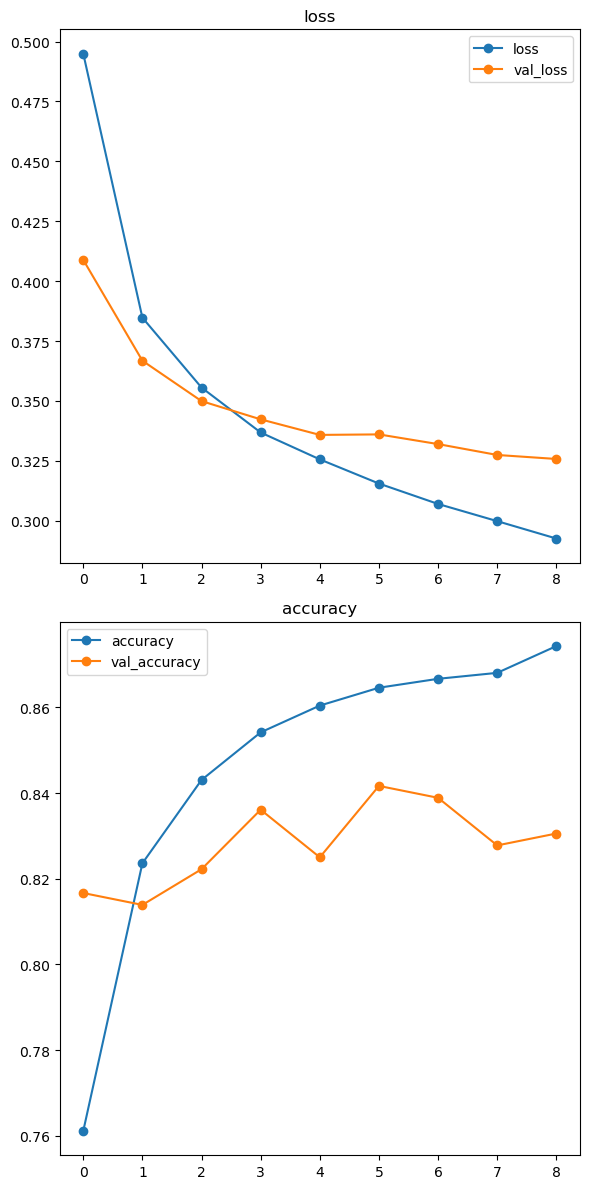

In [35]:
# Apply the custom function plot_history() to see how your model is doing
plot_history(history2);

In [36]:
result=model2.evaluate(X_test_tf, y_test, return_dict=True)
result

19/19 [==============================] - 0s 2ms/step - loss: 0.3560 - accuracy: 0.8336


{'loss': 0.35596972703933716, 'accuracy': 0.8336106538772583}

In [37]:
# make predictions
y_pred_test2= model2.predict(X_test_tf)
y_pred_test2[:5]

19/19 [==============================] - 0s 1ms/step


array([[0.20057558],
       [0.7157875 ],
       [0.45213553],
       [0.4026226 ],
       [0.9953028 ]], dtype=float32)

In [38]:
#evaluate with sklearn metrics
y_pred_test2 = np.round(y_pred_test2)
y_pred_test[:5]

array([[0.],
       [1.],
       [0.],
       [0.],
       [1.]], dtype=float32)

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       397
           1       0.76      0.74      0.75       204

    accuracy                           0.83       601
   macro avg       0.82      0.81      0.81       601
weighted avg       0.83      0.83      0.83       601



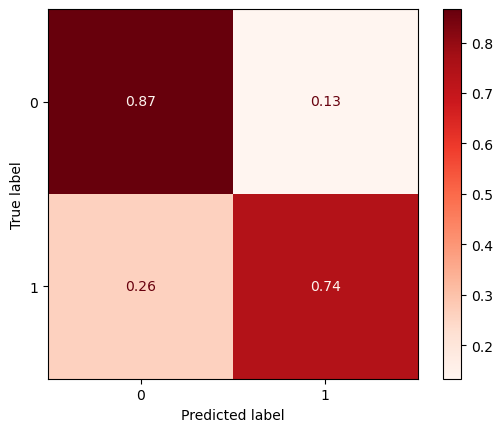

In [39]:
print(classification_report(y_test, y_pred_test2))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, cmap='Reds', normalize="true");

#  Evaluate Model

*  The model 1 has an accuracy score of 0.82
*  The model 2 using keras tuner has an accuracy score of 0.83
*  Of the models the default model performs the best

*  Both models show a point where the models become overfit
    *  Perhaps using a lower patience during early stopping would prevent this.